In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, confusion_matrix, make_scorer, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support,f1_score,fbeta_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn import tree

from myFunctions import print_metrics_test, plot_feature_importances

import warnings
warnings.filterwarnings('ignore')

# Import Cleaned Data

In [33]:
data = pd.read_csv('../csv_files/processed_data.csv',index_col=0)

In [34]:
# removing point features
data = data.drop(['PTS_home','PTS_away'],axis=1)
data.head()

,SEASON,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,...,BLK_home,PF_home,STL_home,TO_home,BLK_away,PF_away,STL_away,TO_away,HOME_TEAM,VISITOR_TEAM
0,2019,0.35400,0.90000,0.22900,22.00000,47.00000,0.40200,0.76200,0.22600,20.00000,...,8.00000,18.00000,7.00000,10.00000,6.00000,11.00000,7.00000,16.00000,Hornets,Bucks
1,2019,0.37200,0.83300,0.35900,24.00000,39.00000,0.50600,0.75000,0.27800,26.00000,...,3.00000,22.00000,6.00000,13.00000,8.00000,22.00000,8.00000,15.00000,Hornets,Bucks
2,2013,0.43400,0.75000,0.58800,30.00000,43.00000,0.43300,0.94100,0.35700,29.00000,...,7.00000,17.00000,2.00000,8.00000,8.00000,23.00000,8.00000,12.00000,Hornets,Bucks
3,2013,0.44300,0.61300,0.20000,20.00000,54.00000,0.33300,0.75000,0.29400,17.00000,...,4.00000,17.00000,5.00000,17.00000,9.00000,22.00000,10.00000,9.00000,Hornets,Bucks
4,2012,0.46300,0.70800,0.44400,23.00000,52.00000,0.39100,0.66700,0.31000,23.00000,...,5.00000,18.00000,6.00000,14.00000,3.00000,20.00000,6.00000,12.00000,Hornets,Bucks


In [35]:
data.columns

Index(['SEASON', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home',
       'REB_home', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
       'REB_away', 'HOME_TEAM_WINS', 'BLK_home', 'PF_home', 'STL_home',
       'TO_home', 'BLK_away', 'PF_away', 'STL_away', 'TO_away', 'HOME_TEAM',
       'VISITOR_TEAM'],
      dtype='object')

# Split Train and Test Data

In [36]:
# split data into training(2003 - 2018 games) and test data(2019 games)
season_2004_2018 = data[data['SEASON'] != 2019].drop('SEASON',axis=1)
season_2019 = data[data['SEASON'] == 2019].drop('SEASON',axis=1)

In [37]:
# split data into features and target for training data
X_train = season_2004_2018.drop('HOME_TEAM_WINS',axis=1).drop(['HOME_TEAM','VISITOR_TEAM'],axis=1)
y_train = season_2004_2018['HOME_TEAM_WINS']

In [38]:
# split data into features and target for test data
X_test = season_2019.drop('HOME_TEAM_WINS',axis=1).drop(['HOME_TEAM','VISITOR_TEAM'],axis=1)
y_test = season_2019['HOME_TEAM_WINS']

In [39]:
X_test.head()

,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,BLK_home,PF_home,STL_home,TO_home,BLK_away,PF_away,STL_away,TO_away
0,0.35400,0.90000,0.22900,22.00000,47.00000,0.40200,0.76200,0.22600,20.00000,61.00000,8.00000,18.00000,7.00000,10.00000,6.00000,11.00000,7.00000,16.00000
1,0.37200,0.83300,0.35900,24.00000,39.00000,0.50600,0.75000,0.27800,26.00000,53.00000,3.00000,22.00000,6.00000,13.00000,8.00000,22.00000,8.00000,15.00000
50,0.35900,0.86400,0.30200,20.00000,47.00000,0.53800,0.66700,0.35900,24.00000,57.00000,4.00000,23.00000,12.00000,15.00000,6.00000,20.00000,8.00000,17.00000
70,0.41800,0.80600,0.41900,21.00000,54.00000,0.42900,0.79400,0.36700,18.00000,54.00000,3.00000,28.00000,4.00000,19.00000,11.00000,28.00000,7.00000,15.00000
94,0.45800,0.80000,0.28600,26.00000,45.00000,0.49500,0.76700,0.25600,29.00000,52.00000,3.00000,24.00000,8.00000,16.00000,4.00000,12.00000,11.00000,11.00000


In [40]:
y_test.head()

0     0
1     0
50    0
70    0
94    0
Name: HOME_TEAM_WINS, dtype: int64

# Descriptive Statistics

## Home vs Away Stats

In [41]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
season_2004_2018.describe()

,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,BLK_home,PF_home,STL_home,TO_home,BLK_away,PF_away,STL_away,TO_away
count,22131.00000,22131.00000,22131.00000,22131.00000,22131.00000,22131.00000,22131.00000,22131.00000,22131.00000,22131.00000,22131.00000,22131.00000,22131.00000,22131.00000,22131.00000,22131.00000,22131.00000,22131.00000,22131.00000
mean,0.45972,0.75753,0.35529,22.41137,43.06028,0.44787,0.75565,0.34858,20.98269,41.74032,0.59695,5.12462,20.84908,7.62582,13.79038,4.58497,21.60187,7.55700,14.11278
std,0.05680,0.10043,0.11575,5.14131,6.56990,0.05561,0.10308,0.11378,5.05352,6.46388,0.49052,2.63612,4.54775,2.95022,3.93899,2.44141,4.72867,2.90593,4.01759
min,0.25000,0.14300,0.00000,6.00000,15.00000,0.24400,0.14300,0.00000,4.00000,19.00000,0.00000,0.00000,7.00000,0.00000,2.00000,0.00000,5.00000,0.00000,3.00000
25%,0.42000,0.69600,0.28000,19.00000,39.00000,0.41000,0.69200,0.27300,17.00000,37.00000,0.00000,3.00000,18.00000,6.00000,11.00000,3.00000,18.00000,6.00000,11.00000
50%,0.45800,0.76300,0.35500,22.00000,43.00000,0.44700,0.76200,0.34800,21.00000,41.00000,1.00000,5.00000,21.00000,7.00000,14.00000,4.00000,21.00000,7.00000,14.00000
75%,0.50000,0.82600,0.42900,26.00000,47.00000,0.48500,0.82600,0.42100,24.00000,46.00000,1.00000,7.00000,24.00000,9.00000,16.00000,6.00000,25.00000,9.00000,17.00000
max,0.68400,1.00000,1.00000,47.00000,72.00000,0.67000,1.00000,1.00000,46.00000,81.00000,1.00000,19.00000,41.00000,22.00000,32.00000,19.00000,45.00000,21.00000,37.00000


Based on the descriptive statistics above:
* Every average stat at home is better than average stat away
    * REB_home (43.06) > REB_away (41.74)
    * AST_home (22.41) > AST_away (20.98)
    * FG_PCT_home (0.4597) > FG_PCT_away (0.4478)
    * FT_PCT_home (0.7575) > FT_PCT_away (0.7556)
    * FG3_PCT_home (0.3552) > FG3_PCT_away (0.3485)

## 2019 Stats vs Last 16 Seasons 

In [42]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
season_2019.describe()

,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,BLK_home,PF_home,STL_home,TO_home,BLK_away,PF_away,STL_away,TO_away
count,965.00000,965.00000,965.00000,965.00000,965.00000,965.00000,965.00000,965.00000,965.00000,965.00000,965.00000,965.00000,965.00000,965.00000,965.00000,965.00000,965.00000,965.00000,965.00000
mean,0.46397,0.76579,0.35928,24.82591,45.79067,0.45396,0.76847,0.35172,23.78964,44.36684,0.54715,5.13264,20.60000,7.60000,14.33161,4.86425,20.99378,7.85181,14.20622
std,0.05663,0.09946,0.08660,4.87678,6.67936,0.05487,0.10407,0.08598,4.95418,6.71471,0.49803,2.61995,4.41630,2.90149,4.29173,2.45694,4.46795,3.04391,4.31729
min,0.26900,0.40000,0.11800,11.00000,25.00000,0.30800,0.42900,0.09400,10.00000,27.00000,0.00000,0.00000,6.00000,0.00000,3.00000,0.00000,10.00000,0.00000,3.00000
25%,0.42500,0.70000,0.30000,21.00000,41.00000,0.41600,0.70400,0.29400,20.00000,40.00000,0.00000,3.00000,18.00000,6.00000,11.00000,3.00000,18.00000,6.00000,11.00000
50%,0.46300,0.77800,0.35700,25.00000,46.00000,0.45300,0.77300,0.35300,24.00000,44.00000,1.00000,5.00000,21.00000,7.00000,14.00000,5.00000,21.00000,8.00000,14.00000
75%,0.50600,0.83300,0.41900,28.00000,50.00000,0.48900,0.84000,0.40600,27.00000,49.00000,1.00000,7.00000,23.00000,9.00000,17.00000,6.00000,24.00000,10.00000,17.00000
max,0.63300,1.00000,0.60000,43.00000,67.00000,0.67400,1.00000,0.68000,40.00000,65.00000,1.00000,20.00000,35.00000,18.00000,29.00000,14.00000,35.00000,18.00000,30.00000


* Home
    * 2019_REB_home (45.79) > 16_REB_home (43.06)
    * 2019_AST_home (24.82) > 16_AST_home (22.41)
    * 2019_FG_PCT_home (0.4639) > 16_FG_PCT_home (0.4597)
    * 2019_FT_PCT_home (0.7657) > 16_FT_PCT_home (0.7575)
    * 2019_FG3_PCT_home (0.3592) > 16_FG3_PCT_home (0.3552)
* Away
    * 2019_REB_away (44.36) > 16_REB_away (41.74)
    * 2019_AST_away (23.78) > 16_AST_away (20.98)
    * 2019_FG_PCT_away (0.4539) > 16_FG_PCT_away (0.4478)
    * 2019_FT_PCT_away (0.7684) > 16_FT_PCT_away (0.7556)
    * 2019_FG3_PCT_away (0.3517) > 16_FG3_PCT_away (0.3485)

In [43]:
# stats_2019 = season_2019.describe()
# stats_2019['FG_PCT'] = (stats_2019['FG_PCT_home'] + stats_2019['FG_PCT_away'])/2
# stats_2019['FT_PCT'] = (stats_2019['FT_PCT_home'] + stats_2019['FT_PCT_away'])/2
# stats_2019['FG3_PCT'] = (stats_2019['FG3_PCT_home'] + stats_2019['FG3_PCT_away'])/2
# stats_2019['PTS'] = (stats_2019['FG3_PCT_home'] + stats_2019['FG3_PCT_away'])/2
# stats_2019['AST_PCT'] = (stats_2019['AST_home'] + stats_2019['AST_away'])/2
# stats_2019['REB_PCT'] = (stats_2019['REB_home'] + stats_2019['REB_away'])/2
# stats.head()

# Multicollinearity

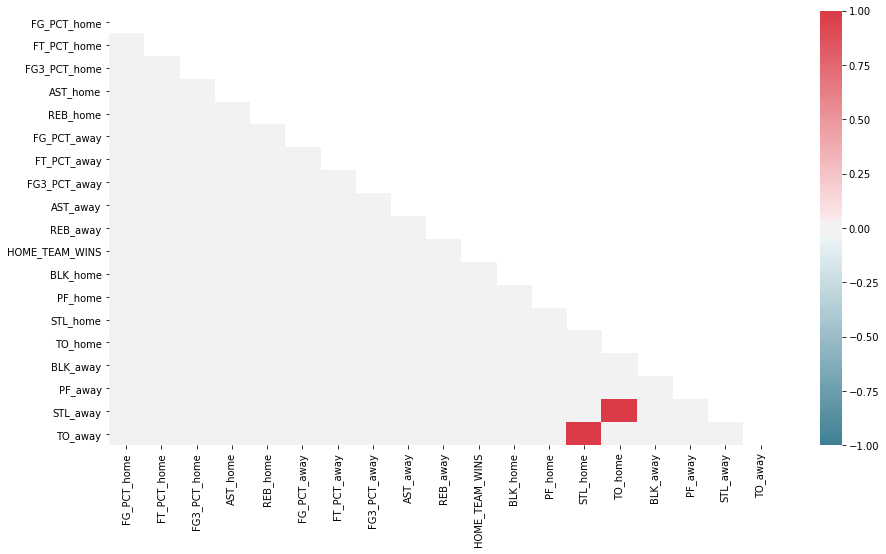

In [44]:
plt.figure(figsize = (15, 8))
sns.heatmap(abs(data.drop('SEASON',axis=1).corr())> 0.70, 
            mask=np.triu(np.ones_like(data.drop('SEASON',axis=1).corr(),dtype=np.bool)),
            cmap = sns.diverging_palette(220,10,as_cmap=True),
           vmax=1,vmin=-1,center=0);

Steals and Turnovers are expected to be correlated with each other. If a team makes a steal, the opposing team will be marked with a turnover.

# Normalize Data

In [45]:
# normalize training data
X_train = X_train.apply(lambda x : (x - x.min()) /(x.max() - x.min()), axis=0)
X_train.head()

# normalize testing data
X_test = X_test.apply(lambda x : (x - x.min()) /(x.max() - x.min()), axis=0)
X_test.head()

,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,BLK_home,PF_home,STL_home,TO_home,BLK_away,PF_away,STL_away,TO_away
0,0.23352,0.83333,0.23029,0.34375,0.52381,0.25683,0.58319,0.22526,0.33333,0.89474,0.40000,0.41379,0.38889,0.26923,0.42857,0.04000,0.38889,0.48148
1,0.28297,0.72167,0.50000,0.40625,0.33333,0.54098,0.56217,0.31399,0.53333,0.68421,0.15000,0.55172,0.33333,0.38462,0.57143,0.48000,0.44444,0.44444
50,0.24725,0.77333,0.38174,0.28125,0.52381,0.62842,0.41681,0.45222,0.46667,0.78947,0.20000,0.58621,0.66667,0.46154,0.42857,0.40000,0.44444,0.51852
70,0.40934,0.67667,0.62448,0.31250,0.69048,0.33060,0.63923,0.46587,0.26667,0.71053,0.15000,0.75862,0.22222,0.61538,0.78571,0.72000,0.38889,0.44444
94,0.51923,0.66667,0.34855,0.46875,0.47619,0.51093,0.59194,0.27645,0.63333,0.65789,0.15000,0.62069,0.44444,0.50000,0.28571,0.08000,0.61111,0.29630


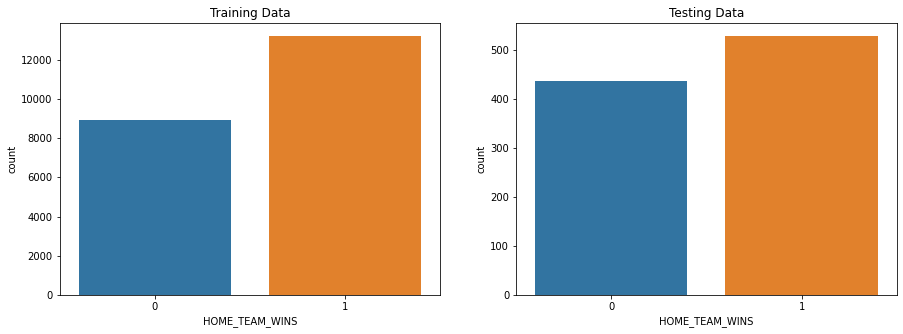

In [46]:
fig,ax =plt.subplots(1,2,figsize=(15,5))
# plt.subplots_adjust(hspace=0.4, wspace=1)
sns.countplot(x='HOME_TEAM_WINS',data=pd.DataFrame(y_train), ax=ax[0]).set_title('Training Data')
sns.countplot(x='HOME_TEAM_WINS',data=pd.DataFrame(y_test), ax=ax[1]).set_title('Testing Data')
plt.savefig('../images/train_test_split.png')
fig.show()

# Logistic Regression

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. The model outputs the probability (a number between 0 and 1) for a given dependent value and classifies the value as either binary number 0 or 1.

In [47]:
# logistic regression classifier
logmodel = LogisticRegression()
# fit the model according to the given training data: features and labels
logmodel.fit(X_train,y_train)

# predict class labels for samples in X_train
y_hat_train = logmodel.predict(X_train)
# predict class labels for samples in X_test
y_hat_test = logmodel.predict(X_test)

# roc curve - auc train
train_fpr_logmodel, train_tpr_logmodel, train_thresholds_logmodel = roc_curve(y_train, y_hat_train)
# roc curve - auc test
test_fpr_logmodel, test_tpr_logmodel, test_thresholds_logmodel = roc_curve(y_test, y_hat_test)

# append classification results
logmodel_results = [logmodel.__class__,accuracy_score(y_test, y_hat_test),roc_auc_score(y_test, y_hat_test)]
alg = pd.DataFrame([logmodel_results])

In [48]:
logmodel_results

[sklearn.linear_model._logistic.LogisticRegression,
 0.8963730569948186,
 0.88696388946675]

In [49]:
# actual probability that a data point belongs to a given class
logmodel.predict_proba(X_test)

array([[9.81218105e-01, 1.87818951e-02],
       [9.97979826e-01, 2.02017410e-03],
       [9.99753888e-01, 2.46111625e-04],
       ...,
       [9.38536727e-01, 6.14632732e-02],
       [9.89667268e-01, 1.03327322e-02],
       [4.64860142e-01, 5.35139858e-01]])

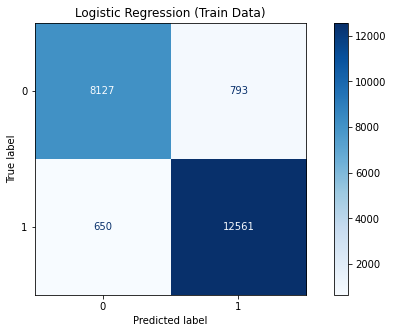

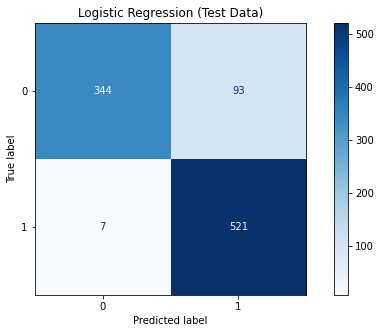

In [50]:
# confusion matrix visualization for train data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(logmodel, X_train, y_train,cmap=plt.cm.Blues,ax=ax)
plt.title('Logistic Regression (Train Data)')
plt.show();

# confusion matrix visualization for test data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(logmodel, X_test, y_test,cmap=plt.cm.Blues,ax=ax)
plt.title('Logistic Regression (Test Data)')
plt.show();

In [51]:
# evaluation metrics for train data
print_metrics_test(y_train,logmodel.predict(X_train),train_fpr_logmodel,train_tpr_logmodel,'Training Data')

print('\n')

# evaluation metrics for test data
print_metrics_test(y_test,logmodel.predict(X_test),test_fpr_logmodel,test_tpr_logmodel,'Test Data')

Training Data
-------------------------
Precision Score: 0.9406170435824472
Recall Score: 0.9507985769434563
Accuracy Score: 0.9347973430933983
F1 Score: 0.9456804065499719
AUC: 0.9309486158259882


Test Data
-------------------------
Precision Score: 0.8485342019543974
Recall Score: 0.9867424242424242
Accuracy Score: 0.8963730569948186
F1 Score: 0.9124343257443083
AUC: 0.88696388946675


# Decision Trees

A decision tree is one of the supervised machine learning algorithms, this algorithm can be used for regression and classification problems — yet, is mostly used for classification problems. A decision tree follows a set of if-else conditions to visualize the data and classify it according to the conditions.

## GridSearchCV for Decision Trees

In [52]:
clf = DecisionTreeClassifier(criterion='entropy',
                                 max_depth=None,
                                 min_samples_leaf=5,
                                 min_samples_split=10)

In [53]:
# dt_param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 2, 3, 4, 5, 6],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 3, 4, 5, 6]
# }

# # Instantiate GridSearchCV
# clf = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)

# print("Best Parameter Combination Found During Grid Search:")
# clf.best_params_

# # output
# # {'criterion': 'entropy',
# #  'max_depth': None,
# #  'min_samples_leaf': 5,
# #  'min_samples_split': 10}

In [54]:
# Fit to the data
clf.fit(X_train, y_train)

# predict class labels for samples in X_train
y_hat_train = clf.predict(X_train)
# predict class labels for samples in X_test
y_hat_test = clf.predict(X_test)

# roc curve - auc train
train_fpr_clf, train_tpr_clf, train_thresholds_clf = roc_curve(y_train, y_hat_train)
# roc curve - auc test
test_fpr_clf, test_tpr_clf, test_thresholds_clf = roc_curve(y_test, y_hat_test)

# append classification results
clf_results = [clf.__class__,accuracy_score(y_test, y_hat_test),roc_auc_score(y_test, y_hat_test)]
alg = alg.append([clf_results])

In [55]:
## Decision Tree Visual
# fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
# tree.plot_tree(clf,
#                feature_names = final_data.columns, 
#                class_names=np.unique(y).astype('str'),
#                filled = True)
# plt.show()

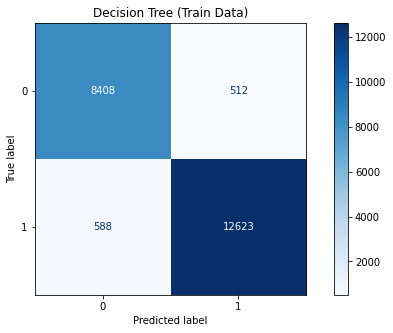

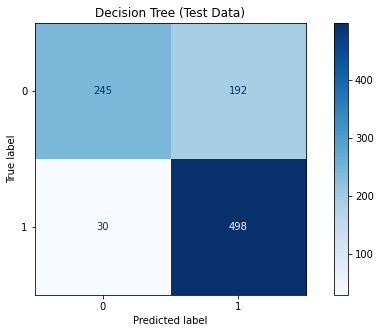

In [56]:
# confusion matrix visualization for train data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(clf, X_train, y_train,cmap=plt.cm.Blues,ax=ax)
plt.title('Decision Tree (Train Data)')
plt.show();

# confusion matrix visualization for test data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(clf, X_test, y_test,cmap=plt.cm.Blues,ax=ax)
plt.title('Decision Tree (Test Data)')
plt.show();

In [57]:
# evaluation metrics for train data
print_metrics_test(y_train,clf.predict(X_train),train_fpr_clf,train_tpr_clf,'Test Data')

print('\n')

# evaluation metrics for test data
print_metrics_test(y_test,clf.predict(X_test),test_fpr_clf,test_tpr_clf,'Training Data')

Test Data
-------------------------
Precision Score: 0.9610201751046822
Recall Score: 0.9554916357580804
Accuracy Score: 0.9502959649360625
F1 Score: 0.9582479313747817
AUC: 0.9490462663095335


Training Data
-------------------------
Precision Score: 0.7217391304347827
Recall Score: 0.9431818181818182
Accuracy Score: 0.7699481865284974
F1 Score: 0.8177339901477834
AUC: 0.7519112752236323


# Random Forest

The Random Forest algorithm is a supervised learning algorithm that can be used both for classification and regression tasks. The random forest algorithm is an ensemble (algorithm that makes use of more than one model to make a prediction) of decision trees. 

An ensemble of trees using the same dataset will give us the same tree. To create high variance among all trees, we use bagging and subspace sampling method techniques increasing variability with each technique.
* Bootstrap Aggregation (Bagging) - train trees using different samples of data by sampling with replacement
* Subspace Sampling Method - randomly select subset of features to use as predictors for each node when training a decision tree, instead of using all predictors available at each node

In [58]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth= 5)

# Fit the classifier
random_forest.fit(X_train, y_train)

# predict class labels for samples in X_train
y_hat_train = random_forest.predict(X_train)
# predict class labels for samples in X_test
y_hat_test = random_forest.predict(X_test)

# roc curve - auc train
train_fpr_random_forest, train_tpr_random_forest, train_thresholds_random_forest = roc_curve(y_train, y_hat_train)
# roc curve - auc test
test_fpr_random_forest, test_tpr_random_forest, test_thresholds_random_forest = roc_curve(y_test, y_hat_test)

# append classification results
random_forest_results = [random_forest.__class__,accuracy_score(y_test, y_hat_test),roc_auc_score(y_test, y_hat_test)]
alg = alg.append([random_forest_results])

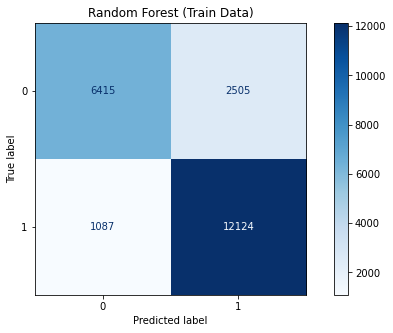

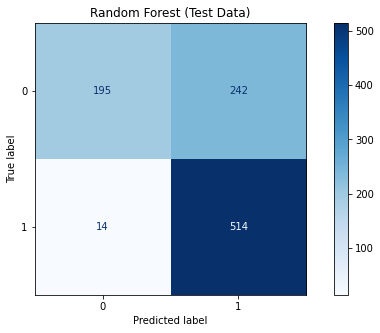

In [59]:
# confusion matrix visualization for train data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(random_forest, X_train, y_train,cmap=plt.cm.Blues,ax=ax)
plt.title('Random Forest (Train Data)')
plt.show();

# confusion matrix visualization for test data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(random_forest, X_test, y_test,cmap=plt.cm.Blues,ax=ax)
plt.title('Random Forest (Test Data)')
plt.show();

In [60]:
# evaluation metrics for train data
print_metrics_test(y_train,random_forest.predict(X_train),train_fpr_random_forest,train_tpr_random_forest,'Training Data')

print('\n')

# evaluation metrics for test data
print_metrics_test(y_test,random_forest.predict(X_test),test_fpr_random_forest,test_tpr_random_forest,'Test Data')

Training Data
-------------------------
Precision Score: 0.8287647822817691
Recall Score: 0.9177200817500568
Accuracy Score: 0.8376937327730333
F1 Score: 0.8709770114942529
AUC: 0.8184452426687504


Test Data
-------------------------
Precision Score: 0.6798941798941799
Recall Score: 0.9734848484848485
Accuracy Score: 0.7347150259067358
F1 Score: 0.8006230529595015
AUC: 0.7098545523888773


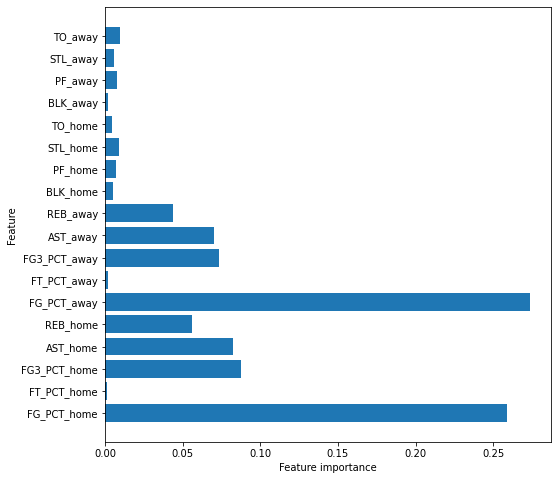

In [61]:
plot_feature_importances(random_forest,X_train)

# K-Nearest Neighbors

K-Nearest Neighbors is a supervised learning algorithm that can be used for both Classification and Regression tasks. A value is assigned a class which is most common among its K nearest neighbors, K being the number of neighbors. If K = 3, a value looks at the nearest 3 neighbors by calculating the distance between the value and class values.

In [62]:
# function to figure out the best number of for k-neighbors
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

In [63]:
find_best_k(X_train, y_train, X_test, y_test)

Best Value for k: 7
F1-Score: 0.8883116883116883


In [64]:
# Instantiate KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=25, metric='euclidean')

# Fit the classifier
knn.fit(X_train, y_train)

# predict class labels for samples in X_train
y_hat_train = knn.predict(X_train)
# predict class labels for samples in X_test
y_hat_test = knn.predict(X_test)

# roc curve - auc train
train_fpr_knn, train_tpr_knn, train_thresholds_knn = roc_curve(y_train, y_hat_train)
# roc curve - auc test
test_fpr_knn, test_tpr_knn, test_thresholds_knn = roc_curve(y_test, y_hat_test)

# append classification results
knn_results = [knn.__class__,accuracy_score(y_test, y_hat_test),roc_auc_score(y_test, y_hat_test)]
alg = alg.append([knn_results])

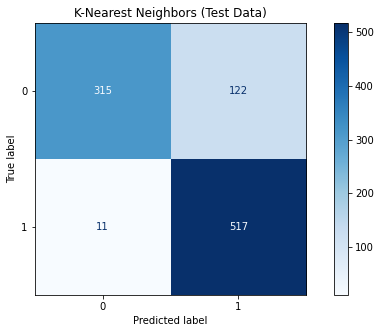

In [65]:
# confusion matrix visualization for test data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(knn, X_test, y_test,cmap=plt.cm.Blues,ax=ax)
plt.title('K-Nearest Neighbors (Test Data)')
plt.show();

In [66]:
# evaluation metrics for test data
print_metrics_test(y_test,knn.predict(X_test),test_fpr_knn,test_tpr_knn,'Test Data')

Test Data
-------------------------
Precision Score: 0.809076682316119
Recall Score: 0.9791666666666666
Accuracy Score: 0.8621761658031089
F1 Score: 0.8860325621251071
AUC: 0.8499952326468344


# XGBoost

In [67]:
XGB = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
# Fit the classifier
XGB.fit(X_train, y_train)

# predict class labels for samples in X_train
y_hat_train = XGB.predict(X_train)
# predict class labels for samples in X_test
y_hat_test = XGB.predict(X_test)

# roc curve - auc train
train_fpr_XGB, train_tpr_XGB, train_thresholds_XGB = roc_curve(y_train, y_hat_train)
# roc curve - auc test
test_fpr_XGB, test_tpr_XGB, test_thresholds_XGB = roc_curve(y_test, y_hat_test)

XGB_results = [XGB.__class__,accuracy_score(y_test, y_hat_test),roc_auc_score(y_test, y_hat_test)]
alg = alg.append([XGB_results])

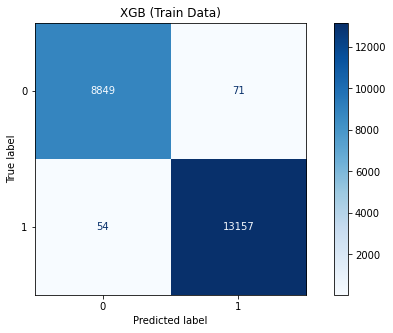

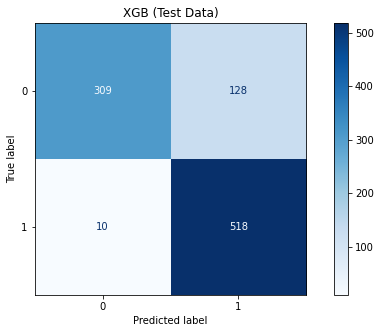

In [68]:
# confusion matrix visualization for train data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(XGB, X_train, y_train,cmap=plt.cm.Blues,ax=ax)
plt.title('XGB (Train Data)')
plt.show();

# confusion matrix visualization for test data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(XGB, X_test, y_test,cmap=plt.cm.Blues,ax=ax)
plt.title('XGB (Test Data)')
plt.show();

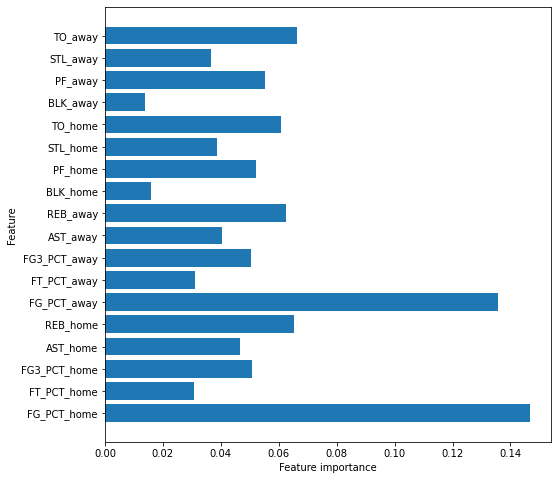

In [69]:
plot_feature_importances(XGB,X_train)

In [70]:
# evaluation metrics for train data
print_metrics_test(y_train,XGB.predict(X_train),train_fpr_XGB,train_tpr_XGB,'Training Data')

print('\n')

# evaluation metrics for test data
print_metrics_test(y_test,XGB.predict(X_test),test_fpr_XGB,test_tpr_XGB,'Test Data')

Training Data
-------------------------
Precision Score: 0.9946325975204112
Recall Score: 0.9959124971614564
Accuracy Score: 0.9943518141972798
F1 Score: 0.9952721358599039
AUC: 0.9939764279529255


Test Data
-------------------------
Precision Score: 0.8018575851393189
Recall Score: 0.9810606060606061
Accuracy Score: 0.8569948186528498
F1 Score: 0.8824531516183987
AUC: 0.8440772137854518


# Gradient Boosting

In [71]:
gboost = GradientBoostingClassifier()

# predict class labels for samples in X_test
gboost.fit(X_train, y_train)

# predict class labels for samples in X_train
y_hat_train = gboost.predict(X_train)
# predict class labels for samples in X_test
y_hat_test = gboost.predict(X_test)

# roc curve - auc train
train_fpr_gboost, train_tpr_gboost, train_thresholds_gboost = roc_curve(y_train, y_hat_train)
# roc curve - auc test
test_fpr_gboost, test_tpr_gboost, test_thresholds_gboost = roc_curve(y_test, y_hat_test)

# append classification results
gboost_results = [gboost.__class__,accuracy_score(y_test, y_hat_test),roc_auc_score(y_test, y_hat_test)]
alg = alg.append([gboost_results])

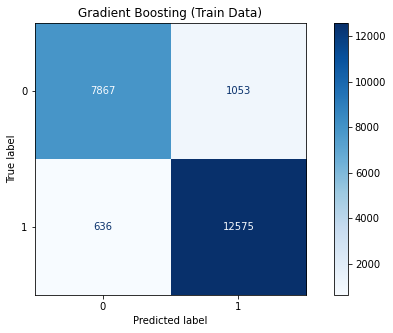

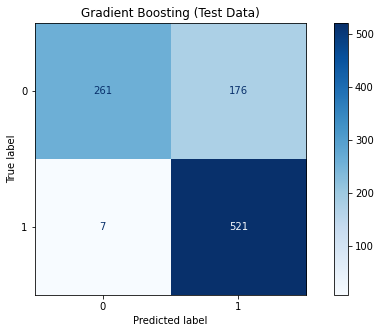

In [72]:
# confusion matrix visualization for train data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(gboost, X_train, y_train,cmap=plt.cm.Blues,ax=ax)
plt.title('Gradient Boosting (Train Data)')
plt.show();

# confusion matrix visualization for test data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(gboost, X_test, y_test,cmap=plt.cm.Blues,ax=ax)
plt.title('Gradient Boosting (Test Data)')
plt.show();

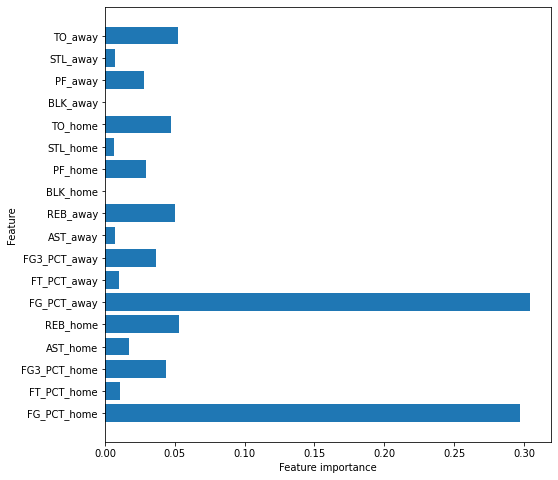

In [73]:
plot_feature_importances(gboost,X_train)

In [74]:
# evaluation metrics for train data
print_metrics_test(y_train,gboost.predict(X_train),train_fpr_gboost,train_tpr_gboost,'Training Data')

print('\n')

# evaluation metrics for test data
print_metrics_test(y_test,gboost.predict(X_test),test_fpr_gboost,test_tpr_gboost,'Test Data')

Training Data
-------------------------
Precision Score: 0.9227326093337247
Recall Score: 0.9518582999015972
Accuracy Score: 0.9236817134336451
F1 Score: 0.9370691903573158
AUC: 0.9169044862736686


Test Data
-------------------------
Precision Score: 0.7474892395982783
Recall Score: 0.9867424242424242
Accuracy Score: 0.8103626943005181
F1 Score: 0.8506122448979592
AUC: 0.7919982144095415


# LinearSVC

In [75]:
# lclf = LinearSVC(random_state=0, tol=1e-5, max_iter=1000)
lclf = svm.SVC()

# predict class labels for samples in X_test
lclf.fit(X_train, y_train)

# predict class labels for samples in X_train
y_hat_train = lclf.predict(X_train)
# predict class labels for samples in X_test
y_hat_test = lclf.predict(X_test)

# roc curve - auc train
train_fpr_lclf, train_tpr_lclf, train_thresholds_lclf = roc_curve(y_train, y_hat_train)
# roc curve - auc test
test_fpr_lclf, test_tpr_lclf, test_thresholds_lclf = roc_curve(y_test, y_hat_test)

# append classification results
lclf_results = [lclf.__class__,accuracy_score(y_test, y_hat_test),roc_auc_score(y_test, y_hat_test)]
alg = alg.append([lclf_results])

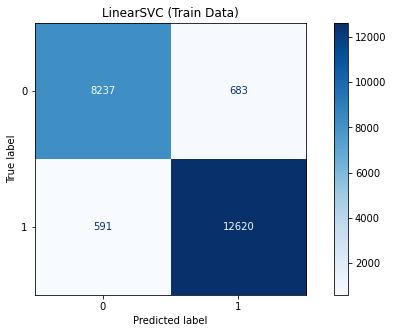

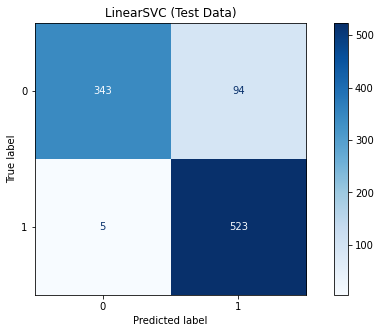

In [99]:
# confusion matrix visualization for train data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(lclf, X_train, y_train,cmap=plt.cm.Blues,ax=ax)
plt.title('LinearSVC (Train Data)')
plt.show();

# confusion matrix visualization for test data
fig, ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(lclf, X_test, y_test,cmap=plt.cm.Blues,ax=ax)
plt.title('LinearSVC (Test Data)')
plt.savefig('../images/linearSVC_confusion_matrix_result.png')
plt.show();

In [100]:
# evaluation metrics for train data
print_metrics_test(y_train,lclf.predict(X_train),train_fpr_lclf,train_tpr_lclf,'Training Data')

print('\n')

# evaluation metrics for test data
print_metrics_test(y_test,lclf.predict(X_test),test_fpr_lclf,test_tpr_lclf,'Test Data')

Training Data
-------------------------
Precision Score: 0.9486581973990829
Recall Score: 0.9552645522670502
Accuracy Score: 0.9424336902986761
F1 Score: 0.9519499132533756
AUC: 0.9393475227702964


Test Data
-------------------------
Precision Score: 0.8476499189627229
Recall Score: 0.990530303030303
Accuracy Score: 0.8974093264248705
F1 Score: 0.9135371179039301
AUC: 0.887713664100964


# Model Evaluation

In [101]:
alg = alg.rename({0:'model',1:'accuracy_score', 2:'roc_auc_score'},axis=1).sort_values(by='accuracy_score', ascending=False)
alg

,model,accuracy_score,roc_auc_score
0,<class 'sklearn.svm._classes.SVC'>,0.89741,0.88771
0,<class 'sklearn.linear_model._logistic.Logisti...,0.89637,0.88696
0,<class 'sklearn.neighbors._classification.KNei...,0.86218,0.85000
0,<class 'xgboost.sklearn.XGBClassifier'>,0.85699,0.84408
0,<class 'sklearn.ensemble._gb.GradientBoostingC...,0.81036,0.79200
0,<class 'sklearn.tree._classes.DecisionTreeClas...,0.78135,0.76430
0,<class 'sklearn.ensemble._forest.RandomForestC...,0.73161,0.70622


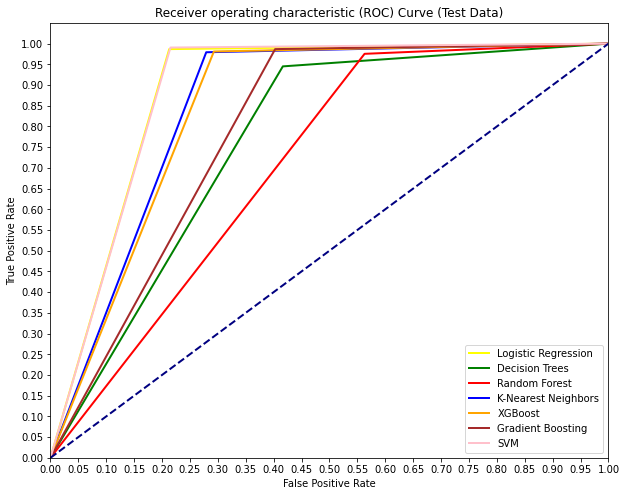

In [102]:
# model plots
plt.figure(figsize=(10,8))
lw = 2

plt.plot(test_fpr_logmodel, test_tpr_logmodel, color='yellow',lw=lw, label='Logistic Regression')
plt.plot(test_fpr_clf, test_tpr_clf, color='green',lw=lw, label='Decision Trees')
plt.plot(test_fpr_random_forest, test_tpr_random_forest, color='red',lw=lw, label='Random Forest')
plt.plot(test_fpr_knn, test_tpr_knn, color='blue',lw=lw, label='K-Nearest Neighbors')
plt.plot(test_fpr_XGB, test_tpr_XGB, color='orange',lw=lw, label='XGBoost')
plt.plot(test_fpr_gboost, test_tpr_gboost, color='brown',lw=lw, label='Gradient Boosting')
plt.plot(test_fpr_lclf, test_tpr_lclf, color='pink',lw=lw, label='SVM')

# Formatting
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve (Test Data)')
plt.legend(loc="lower right")
plt.show()

# Conclusion

Based on the accuracy of all the models, the one with the highest accuracy is Logistic Regression with an accuracy of 82% based on test data. We trained the data using 2004-2018 historical data and tested the first 66 nba games of the 2019 season.

When it comes to NBA basketball games, there is something called an upset which mean there can be cases where a team can do really well but can still lose the game and upsets do happen frequently. The model does not take care of upsets which can be difficult but with an accuracy of 82%, I would consider that a fair accuracy rate.

## Future Iterations

I eventually want to predict NBA games based on the spread. When it comes to spread, different features will be needed to predict games. Because the test data I provided already has the game stats, in a real time basketball game, the performance and stats of the game has not been played out yet. The data will need to be based on only the historical data.